In [50]:
%matplotlib inline
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
from scipy.stats import percentileofscore
import warnings
warnings.filterwarnings('ignore')

### Read data file

In [51]:
df_dl = pd.read_csv('./data/predictions_test.csv')
df_dl_train = pd.read_csv('./data/predictions_train.csv')

df_dict = {}
for i in range(9):
    df_dict[i] = pd.read_csv('./data/data_readers_{}.csv'.format(i))

df_all = pd.read_csv('./data/data_all.csv')
df_all.fillna(0, inplace=True)
df_all.Calcs1.replace(0, 'None', inplace=True)

### Feature processing and engineering

In [52]:
categorical_features = ['Composition', 'Echogenicity', 'Shape', 'Calcs1', 'Calcs2', 'Calcs3', 'MargA']

In [53]:
df_all_categorical = df_all[categorical_features]
df_all_categorical = pd.get_dummies(df_all_categorical)

In [54]:
df_features = df_all_categorical
df_features['Calcs_None'] = df_features.Calcs1_None
df_features['Calcs_Peripheral_eggshell'] = df_features.Calcs1_Peripheral_eggshell + df_features.Calcs2_Peripheral_eggshell + df_features.Calcs3_Peripheral_eggshell
df_features['Calcs_Colloid'] = df_features.Calcs1_Colloid + df_features.Calcs2_Colloid
df_features['Calcs_Macro'] = df_features.Calcs1_Macro + df_features.Calcs2_Macro
df_features['Calcs_PEF'] = df_features.Calcs1_PEF + df_features.Calcs2_PEF
df_features.drop(columns=['Shape_0', 'Calcs1_None', 'Calcs2_0', 'Calcs3_0'], inplace=True)
df_features.drop(columns=['Calcs1_Peripheral_eggshell', 'Calcs2_Peripheral_eggshell', 'Calcs3_Peripheral_eggshell'], inplace=True)
df_features.drop(columns=['Calcs1_Colloid', 'Calcs2_Colloid'], inplace=True)
df_features.drop(columns=['Calcs1_Macro', 'Calcs2_Macro'], inplace=True)
df_features.drop(columns=['Calcs1_PEF', 'Calcs2_PEF'], inplace=True)
print(df_features.columns)

Index([u'Composition_Cannot tell', u'Composition_Cystic',
       u'Composition_Entirely or almost entirely solid',
       u'Composition_Mixed cystic_solid', u'Composition_Spongiform',
       u'Echogenicity_Cant classify', u'Echogenicity_Hyper',
       u'Echogenicity_Iso', u'Echogenicity_Mild Hypo',
       u'Echogenicity_Very Hypo', u'Shape_cant assess', u'Shape_n', u'Shape_y',
       u'MargA_Cant classify', u'MargA_Ill-defined', u'MargA_Lobulated',
       u'MargA_Well-defined', u'Calcs_None', u'Calcs_Peripheral_eggshell',
       u'Calcs_Colloid', u'Calcs_Macro', u'Calcs_PEF'],
      dtype='object')


### Remove rows not present in deep learning data frame

In [55]:
df_features['ID'] = df_all['ID']
cv_ids = np.intersect1d(df_all['ID'], df_dl_train['ID'])
df_features = df_features[df_features.ID.isin(cv_ids)]
df_cv = df_all[df_all.ID.isin(cv_ids)]
df_features.drop(columns=['ID'], inplace=True)
print(len(df_features))

1278


### Percentiles for TI-RADS levels

In [56]:
w = np.array([[2, 0, 2, 1, 0, 1, 1, 1, 2, 3, 0, 0, 3, 0, 0, 2, 0, 0, 2, 0, 1, 3]])

X_cv = df_features.as_matrix()

x_cyst = X_cv[:, 1]
x_cyst = np.abs(x_cyst - 1)
x_spon = X_cv[:, 4]
x_spon = np.abs(x_spon - 1)

X_cv = X_cv * np.expand_dims(x_cyst, axis=-1)
X_cv = X_cv * np.expand_dims(x_spon, axis=-1)

tirads_points_cv = np.dot(X_cv, w.T).flatten()

In [57]:
dl_level3_p = percentileofscore(tirads_points_cv, 2.5)
dl_level4_p = percentileofscore(tirads_points_cv, 3.5)
dl_level5_p = percentileofscore(tirads_points_cv, 6.5)

### Deep learning

In [58]:
y_score_dl_test = df_dl['Prediction'].as_matrix()
y_true_dl_test = df_dl['Cancer'].as_matrix()

df_all = pd.read_csv('./data/data_all.csv')
df_all['Size'] = df_all.apply(lambda x: max(x.Length, x.Width, x.Thickness), axis=1)
df_dl = df_dl.merge(df_all[['ID', 'Size']], on='ID')
size_dl = df_dl['Size'].as_matrix().flatten()

y_score_dl_train = df_dl_train['Prediction'].as_matrix()

dl_th3 = np.percentile(y_score_dl_train, dl_level3_p)
dl_th4 = np.percentile(y_score_dl_train, dl_level4_p)
dl_th5 = np.percentile(y_score_dl_train, dl_level5_p)

print('dl_th3 = {}'.format(dl_th3))
print('dl_th4 = {}'.format(dl_th4))
print('dl_th5 = {}'.format(dl_th5))

y_pred_dl_test = np.zeros_like(y_score_dl_test)
for i in range(len(y_score_dl_test)):
    p = y_score_dl_test[i]
    s = size_dl[i]
    if (dl_th3 < p <= dl_th4 and s >= 25) or (dl_th4 < p <= dl_th5 and s >= 15) or (dl_th5 < p and s >= 10):
        y_pred_dl_test[i] = 1.

dl_th3 = 0.420099882907
dl_th4 = 0.506129936736
dl_th5 = 0.694951108224


### Prediction based on TI-RADS

In [59]:
fpr_dl, tpr_dl, _ = roc_curve(y_true_dl_test, y_pred_dl_test)

fpr = {}
tpr = {}
for i in range(9):
    fpr_reader, tpr_reader, _ = roc_curve(df_dict[i]['Cancer'].as_matrix(), df_dict[i]['Reader TIRADS rec'].as_matrix())
    fpr[i] = fpr_reader[1]
    tpr[i] = tpr_reader[1]

### Results analysis

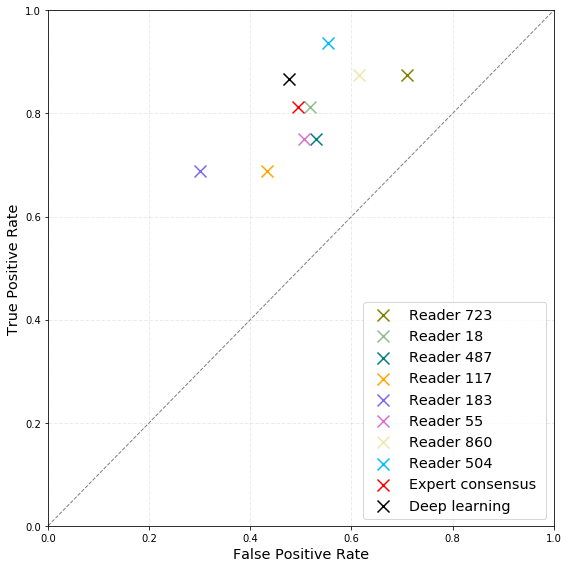

In [60]:
plt.figure(figsize=(8, 8))
colors = ['olive', 'darkseagreen', 'teal', 'orange', 'mediumslateblue', 'orchid', 'palegoldenrod', 'deepskyblue', 'red']
for i in range(9):
    user_id = df_dict[i]['User ID'].as_matrix()[0]
    label = 'Reader {} '.format(user_id)
    if user_id == 0: label = 'Expert consensus '
    plt.scatter(fpr[i], tpr[i], s=144, color=colors[i], marker='x', label=label)
plt.scatter(fpr_dl[1], tpr_dl[1], s=144, color='black', marker='x', label='Deep learning')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('', fontsize='xx-large')
plt.xlabel('False Positive Rate', fontsize='x-large')
plt.ylabel('True Positive Rate', fontsize='x-large')
plt.legend(loc='lower right', fontsize='x-large')
plt.grid(color='silver', alpha=0.3, linestyle='--', linewidth=1)
plt.tight_layout()